In [ ]:
import pandas as pd

# Encoding dictionaries for categorical columns
encodings = {
    'request_type': {
        'bank_detail_update': 0,
        'credential_request': 1,
        'document_download': 2,
        'executive_request': 3,
        'gift_card_request': 4,
        'invoice_payment': 5,
        'invoice_verification': 6,
        'legal_threat': 7,
        'link_click': 8,
        'meeting_request': 9,
        'none': 10,
        'sensitive_data_request': 11,
        'urgent_callback': 12,
        'vpn_or_mfa_reset': 13,
        'wire_transfer': 14
    },
    'spf_result': {
        'fail': 0,
        'neutral': 1,
        'none': 2,
        'pass': 3,
        'permerror': 4,
        'softfail': 5,
        'temperror': 6
    },
    'dkim_result': {
        'fail': 0,
        'neutral': 1,
        'none': 2,
        'pass': 3,
        'permerror': 4,
        'policy': 5,
        'temperror': 6
    },
    'dmarc_result': {
        'fail': 0,
        'neutral': 1,
        'none': 2,
        'pass': 3,
        'permerror': 4,
        'softfail': 5,
        'temperror': 6
    },
    'tls_version': {
        'SSL': 0,
        'SSL 3.0': 1,
        'TLS 1.0': 2,
        'TLS 1.1': 3,
        'TLS 1.2': 4,
        'TLS 1.3': 5
    },
    'ssl_validity_status': {
        'error': 0,
        'expired': 1,
        'invalid_chain': 2,
        'mismatch': 3,
        'no_ssl': 4,
        'revoked': 5,
        'self signed': 6,
        'self_signed': 7,
        'valid': 8
    },
    'unique_parent_process_names': {
        '[""]': 0,
        'chrome.exe': 1,
        'firefox.exe': 2,
        'outlook.exe': 3
    }
}

def encode_dataframe(df, inplace=False):
    """
    Apply categorical encodings to a DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame
    inplace (bool): If True, modify the original columns. If False, create new columns with '_encoded' suffix

    Returns:
    pd.DataFrame: Encoded DataFrame
    """
    if not inplace:
        df = df.copy()

    for column, values in encodings.items():
        if column in df.columns:
            if inplace:
                df[column] = df[column].replace(values)
            else:
                df[f'{column}_encoded'] = df[column].replace(values)

    return df

In [ ]:
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras.optimizers import RMSprop,Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

In [ ]:
# d = pd.read_csv("/content/16619_final_V4.csv")
d = pd.read_csv("/content/final-19-12.csv")

In [ ]:
malicious_df = d[d['Final Classification'] == "Malicious"]
Warning_df = d[d['Final Classification'] == "Warning"]
No_Action_df = d[d['Final Classification'] == "No Action"]
Spam_df = d[d['Final Classification'] == "Spam"]
# non_malicious_df = d[d['Final Classification'] != "Malicious"]

malicious_sampled = malicious_df.sample(n=len(malicious_df)-5500, random_state=42) #Randomly drop 2000 from malicious
Warning_sampled = Warning_df.sample(n=len(Warning_df)-2500, random_state=42)
No_Action_sampled = No_Action_df.sample(n=len(No_Action_df)-300, random_state=42)
Spam_sampled = Spam_df.sample(n=len(Spam_df)-300, random_state=42)

df = pd.concat([malicious_sampled, No_Action_sampled,Spam_sampled], ignore_index=True)
df_1 = pd.concat([malicious_sampled, No_Action_sampled,Spam_sampled], ignore_index=True)
print("Original dataset:", len(d))
print("After dropping 2000 malicious:", len(df))
print("Remaining malicious count:", (df['Final Classification']=="Malicious").sum())

Original dataset: 16619
After dropping 2000 malicious: 5751
Remaining malicious count: 2299


In [ ]:
# Show all columns
pd.set_option('display.max_columns', None)
# Show all rows
pd.set_option('display.max_rows', None)

In [ ]:
df.head()

,sender_known_malicious,sender_domain_reputation_score,sender_spoof_detected,sender_temp_email_likelihood,dmarc_enforced,packer_detected,any_file_hash_malicious,max_metadata_suspicious_score,malicious_attachment_count,has_executable_attachment,unscannable_attachment_present,total_yara_match_count,total_ioc_count,max_behavioral_sandbox_score,max_amsi_suspicion_score,any_macro_enabled_document,any_vbscript_javascript_detected,any_active_x_objects_detected,any_network_call_on_open,max_exfiltration_behavior_score,any_exploit_pattern_detected,total_embedded_file_count,max_suspicious_string_entropy_score,max_sandbox_execution_time,unique_parent_process_names,return_path_mismatch_with_from,return_path_known_malicious,return_path_reputation_score,reply_path_known_malicious,reply_path_diff_from_sender,reply_path_reputation_score,smtp_ip_known_malicious,smtp_ip_geo,smtp_ip_asn,smtp_ip_reputation_score,domain_known_malicious,url_count,dns_morphing_detected,domain_tech_stack_match_score,is_high_risk_role_targeted,sender_name_similarity_to_vip,urgency_keywords_present,request_type,content_spam_score,user_marked_as_spam_before,bulk_message_indicator,unsubscribe_link_present,marketing-keywords_detected,html_text_ratio,image_only_email,spf_result,dkim_result,dmarc_result,reverse_dns_valid,tls_version,total_links_detected,url_shortener_detected,url_redirect_chain_length,final_url_known_malicious,url_decoded_spoof_detected,url_reputation_score,ssl_validity_status,site_visual_similarity_to_known_brand,url_rendering_behavior_score,link_rewritten_through_redirector,token_validation_success,total_components_detected_malicious,Analysis_of_the_qrcode_if_present,Final Classification
0,1,0.111036,0,0.966498,0,0,0,0.000000,0,0,0,0,0,0.000000,0.000000e+00,0,0,1,0,0.000000,0,0,0.869796,0.000000e+00,"[""""]",0,0,9.879139e-01,1,0,0.000651,1,0.117614,0.589840,7.600000e-13,0,0,0,1.0,0,0.287282,0.642556,sensitive_data_request,4.753840e-04,0,0,0,0.0,0.0,0,fail,pass,pass,0,TLS 1.2,3,0,0,0,1,0.379746,valid,0.987655,0.511205,0,1,0,1,Malicious
1,0,0.073529,0,0.665674,0,0,0,0.326354,0,0,0,0,0,0.000920,3.549731e-01,0,0,0,0,0.168260,0,0,0.653707,2.660000e-19,"[""""]",0,0,1.510000e-07,1,1,0.024311,1,0.500298,0.676601,4.693730e-04,1,0,0,0.5,0,0.008037,0.017736,none,6.300000e-09,0,0,0,0.0,0.0,0,fail,fail,none,0,TLS 1.2,1,0,0,0,0,0.000059,valid,0.320294,0.845658,0,1,3,0,Malicious
2,0,0.000156,0,0.914945,1,0,0,0.010628,0,0,0,3,0,0.007188,6.900000e-07,1,0,0,1,0.861624,1,0,0.701528,1.260000e-32,"[""""]",0,0,3.880000e-08,0,0,0.023481,1,0.891046,0.770461,2.069384e-03,1,0,1,0.0,0,0.001243,0.651584,none,6.036399e-03,0,0,0,0.0,0.0,0,pass,none,none,0,TLS 1.1,1,0,0,0,0,0.090708,valid,0.661230,0.735338,0,1,0,1,Malicious
3,0,0.011820,0,0.302528,0,0,0,0.072855,0,0,0,0,0,0.000053,1.534954e-03,0,0,0,1,0.789710,0,0,0.670173,1.410000e-17,"[""""]",0,0,2.588486e-02,1,0,0.001624,1,0.888077,0.828542,2.061287e-03,0,0,0,1.0,0,0.000009,0.526985,gift_card_request,6.789800e-04,0,0,0,0.0,0.0,0,fail,fail,pass,0,TLS 1.2,1,0,0,0,0,0.000002,valid,0.309669,0.822824,0,1,0,0,Malicious
4,0,0.036853,0,0.429542,0,0,1,0.104310,0,0,0,0,0,0.000566,2.086080e-04,1,0,1,0,0.438890,0,0,0.655577,4.440000e-141,"[""""]",0,1,1.074357e-01,0,0,0.006585,0,0.949177,0.029691,9.890000e-06,0,0,0,0.5,0,0.004076,0.089202,none,1.196931e-02,0,0,0,0.0,0.0,0,pass,none,fail,0,TLS 1.3,0,0,0,0,1,0.045425,valid,0.880525,0.537209,0,1,5,1,Malicious


In [ ]:
df.shape

(5751, 69)

In [ ]:
# df = encode_dataframe(df, inplace=True)

In [ ]:
le_spf_result = LabelEncoder()
df["spf_result"] = le_spf_result.fit_transform(df["spf_result"])

le_request_type = LabelEncoder()
df["request_type"] = le_request_type.fit_transform(df["request_type"])

le_dkim_result = LabelEncoder()
df["dkim_result"] = le_dkim_result.fit_transform(df["dkim_result"])

le_dmarc_result = LabelEncoder()
df["dmarc_result"] = le_dmarc_result.fit_transform(df["dmarc_result"])

le_tls_version = LabelEncoder()
df["tls_version"] = le_tls_version.fit_transform(df["tls_version"])

le_ssl_validity_status = LabelEncoder()
df["ssl_validity_status"] = le_ssl_validity_status.fit_transform(df["ssl_validity_status"])

le_unique_parent_process_names = LabelEncoder()
df["unique_parent_process_names"] = le_unique_parent_process_names.fit_transform(df["unique_parent_process_names"])

In [ ]:
with open("le_spf_result.pkl", "wb") as f:
    pickle.dump(le_spf_result, f)

with open("le_request_type.pkl", "wb") as f:
    pickle.dump(le_request_type, f)

with open("le_dkim_result.pkl", "wb") as f:
    pickle.dump(le_dkim_result, f)

with open("le_dmarc_result.pkl", "wb") as f:
    pickle.dump(le_dmarc_result, f)

with open("le_tls_version.pkl", "wb") as f:
    pickle.dump(le_tls_version, f)

with open("le_ssl_validity_status.pkl", "wb") as f:
    pickle.dump(le_ssl_validity_status, f)

with open("le_unique_parent_process_names.pkl", "wb") as f:
    pickle.dump(le_unique_parent_process_names, f)

In [ ]:
df.head()

,sender_known_malicious,sender_domain_reputation_score,sender_spoof_detected,sender_temp_email_likelihood,dmarc_enforced,packer_detected,any_file_hash_malicious,max_metadata_suspicious_score,malicious_attachment_count,has_executable_attachment,unscannable_attachment_present,total_yara_match_count,total_ioc_count,max_behavioral_sandbox_score,max_amsi_suspicion_score,any_macro_enabled_document,any_vbscript_javascript_detected,any_active_x_objects_detected,any_network_call_on_open,max_exfiltration_behavior_score,any_exploit_pattern_detected,total_embedded_file_count,max_suspicious_string_entropy_score,max_sandbox_execution_time,unique_parent_process_names,return_path_mismatch_with_from,return_path_known_malicious,return_path_reputation_score,reply_path_known_malicious,reply_path_diff_from_sender,reply_path_reputation_score,smtp_ip_known_malicious,smtp_ip_geo,smtp_ip_asn,smtp_ip_reputation_score,domain_known_malicious,url_count,dns_morphing_detected,domain_tech_stack_match_score,is_high_risk_role_targeted,sender_name_similarity_to_vip,urgency_keywords_present,request_type,content_spam_score,user_marked_as_spam_before,bulk_message_indicator,unsubscribe_link_present,marketing-keywords_detected,html_text_ratio,image_only_email,spf_result,dkim_result,dmarc_result,reverse_dns_valid,tls_version,total_links_detected,url_shortener_detected,url_redirect_chain_length,final_url_known_malicious,url_decoded_spoof_detected,url_reputation_score,ssl_validity_status,site_visual_similarity_to_known_brand,url_rendering_behavior_score,link_rewritten_through_redirector,token_validation_success,total_components_detected_malicious,Analysis_of_the_qrcode_if_present,Final Classification
0,1,0.111036,0,0.966498,0,0,0,0.000000,0,0,0,0,0,0.000000,0.000000e+00,0,0,1,0,0.000000,0,0,0.869796,0.000000e+00,0,0,0,9.879139e-01,1,0,0.000651,1,0.117614,0.589840,7.600000e-13,0,0,0,1.0,0,0.287282,0.642556,11,4.753840e-04,0,0,0,0.0,0.0,0,0,3,3,0,4,3,0,0,0,1,0.379746,8,0.987655,0.511205,0,1,0,1,Malicious
1,0,0.073529,0,0.665674,0,0,0,0.326354,0,0,0,0,0,0.000920,3.549731e-01,0,0,0,0,0.168260,0,0,0.653707,2.660000e-19,0,0,0,1.510000e-07,1,1,0.024311,1,0.500298,0.676601,4.693730e-04,1,0,0,0.5,0,0.008037,0.017736,10,6.300000e-09,0,0,0,0.0,0.0,0,0,0,2,0,4,1,0,0,0,0,0.000059,8,0.320294,0.845658,0,1,3,0,Malicious
2,0,0.000156,0,0.914945,1,0,0,0.010628,0,0,0,3,0,0.007188,6.900000e-07,1,0,0,1,0.861624,1,0,0.701528,1.260000e-32,0,0,0,3.880000e-08,0,0,0.023481,1,0.891046,0.770461,2.069384e-03,1,0,1,0.0,0,0.001243,0.651584,10,6.036399e-03,0,0,0,0.0,0.0,0,3,2,2,0,3,1,0,0,0,0,0.090708,8,0.661230,0.735338,0,1,0,1,Malicious
3,0,0.011820,0,0.302528,0,0,0,0.072855,0,0,0,0,0,0.000053,1.534954e-03,0,0,0,1,0.789710,0,0,0.670173,1.410000e-17,0,0,0,2.588486e-02,1,0,0.001624,1,0.888077,0.828542,2.061287e-03,0,0,0,1.0,0,0.000009,0.526985,4,6.789800e-04,0,0,0,0.0,0.0,0,0,0,3,0,4,1,0,0,0,0,0.000002,8,0.309669,0.822824,0,1,0,0,Malicious
4,0,0.036853,0,0.429542,0,0,1,0.104310,0,0,0,0,0,0.000566,2.086080e-04,1,0,1,0,0.438890,0,0,0.655577,4.440000e-141,0,0,1,1.074357e-01,0,0,0.006585,0,0.949177,0.029691,9.890000e-06,0,0,0,0.5,0,0.004076,0.089202,10,1.196931e-02,0,0,0,0.0,0.0,0,3,2,0,0,5,0,0,0,0,1,0.045425,8,0.880525,0.537209,0,1,5,1,Malicious


In [ ]:
df.shape

(5751, 69)

In [ ]:
###########################################################

In [ ]:
Y = pd.DataFrame()
X = df.drop(["Final Classification"], axis=1)
Y["Classification"] = df["Final Classification"]

ValueError: 'labels' must be of length 'x', not 4

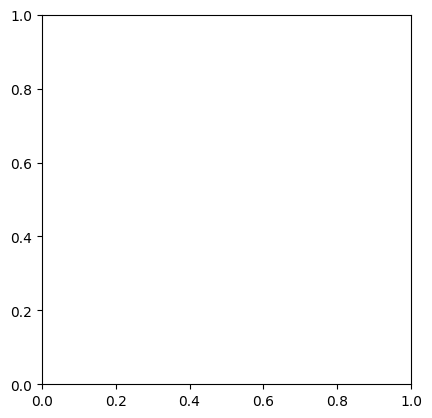

In [ ]:
plt.pie(Y["Classification"].value_counts(),labels=['Malicious','Warning','No Action','Spam'],autopct="%0.2f")
plt.show()

In [ ]:
en = LabelEncoder()
Y['Classification_lable'] = en.fit_transform(Y['Classification'])
with open("label_encoder-output.pkl", "wb") as file:
    pickle.dump(en, file)

In [ ]:
y = Y['Classification_lable']

In [ ]:
X.head()

,sender_known_malicious,sender_domain_reputation_score,sender_spoof_detected,sender_temp_email_likelihood,dmarc_enforced,packer_detected,any_file_hash_malicious,max_metadata_suspicious_score,malicious_attachment_count,has_executable_attachment,unscannable_attachment_present,total_yara_match_count,total_ioc_count,max_behavioral_sandbox_score,max_amsi_suspicion_score,any_macro_enabled_document,any_vbscript_javascript_detected,any_active_x_objects_detected,any_network_call_on_open,max_exfiltration_behavior_score,any_exploit_pattern_detected,total_embedded_file_count,max_suspicious_string_entropy_score,max_sandbox_execution_time,unique_parent_process_names,return_path_mismatch_with_from,return_path_known_malicious,return_path_reputation_score,reply_path_known_malicious,reply_path_diff_from_sender,reply_path_reputation_score,smtp_ip_known_malicious,smtp_ip_geo,smtp_ip_asn,smtp_ip_reputation_score,domain_known_malicious,url_count,dns_morphing_detected,domain_tech_stack_match_score,is_high_risk_role_targeted,sender_name_similarity_to_vip,urgency_keywords_present,request_type,content_spam_score,user_marked_as_spam_before,bulk_message_indicator,unsubscribe_link_present,marketing-keywords_detected,html_text_ratio,image_only_email,spf_result,dkim_result,dmarc_result,reverse_dns_valid,tls_version,total_links_detected,url_shortener_detected,url_redirect_chain_length,final_url_known_malicious,url_decoded_spoof_detected,url_reputation_score,ssl_validity_status,site_visual_similarity_to_known_brand,url_rendering_behavior_score,link_rewritten_through_redirector,token_validation_success,total_components_detected_malicious,Analysis_of_the_qrcode_if_present
0,1,0.111036,0,0.966498,0,0,0,0.000000,0,0,0,0,0,0.000000,0.000000e+00,0,0,1,0,0.000000,0,0,0.869796,0.000000e+00,0,0,0,9.879139e-01,1,0,0.000651,1,0.117614,0.589840,7.600000e-13,0,0,0,1.0,0,0.287282,0.642556,11,4.753840e-04,0,0,0,0.0,0.0,0,0,3,3,0,4,3,0,0,0,1,0.379746,8,0.987655,0.511205,0,1,0,1
1,0,0.073529,0,0.665674,0,0,0,0.326354,0,0,0,0,0,0.000920,3.549731e-01,0,0,0,0,0.168260,0,0,0.653707,2.660000e-19,0,0,0,1.510000e-07,1,1,0.024311,1,0.500298,0.676601,4.693730e-04,1,0,0,0.5,0,0.008037,0.017736,10,6.300000e-09,0,0,0,0.0,0.0,0,0,0,2,0,4,1,0,0,0,0,0.000059,8,0.320294,0.845658,0,1,3,0
2,0,0.000156,0,0.914945,1,0,0,0.010628,0,0,0,3,0,0.007188,6.900000e-07,1,0,0,1,0.861624,1,0,0.701528,1.260000e-32,0,0,0,3.880000e-08,0,0,0.023481,1,0.891046,0.770461,2.069384e-03,1,0,1,0.0,0,0.001243,0.651584,10,6.036399e-03,0,0,0,0.0,0.0,0,3,2,2,0,3,1,0,0,0,0,0.090708,8,0.661230,0.735338,0,1,0,1
3,0,0.011820,0,0.302528,0,0,0,0.072855,0,0,0,0,0,0.000053,1.534954e-03,0,0,0,1,0.789710,0,0,0.670173,1.410000e-17,0,0,0,2.588486e-02,1,0,0.001624,1,0.888077,0.828542,2.061287e-03,0,0,0,1.0,0,0.000009,0.526985,4,6.789800e-04,0,0,0,0.0,0.0,0,0,0,3,0,4,1,0,0,0,0,0.000002,8,0.309669,0.822824,0,1,0,0
4,0,0.036853,0,0.429542,0,0,1,0.104310,0,0,0,0,0,0.000566,2.086080e-04,1,0,1,0,0.438890,0,0,0.655577,4.440000e-141,0,0,1,1.074357e-01,0,0,0.006585,0,0.949177,0.029691,9.890000e-06,0,0,0,0.5,0,0.004076,0.089202,10,1.196931e-02,0,0,0,0.0,0.0,0,3,2,0,0,5,0,0,0,0,1,0.045425,8,0.880525,0.537209,0,1,5,1


In [ ]:
##################################

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=47)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(4600, 68)
(4600,)
(1151, 68)


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(3680, 68)
(920, 68)
(3680,)
(920,)


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

# Suppose X is your (1000x68) data and y is your label vector
# X_sparse = csr_matrix(x)  # convert to sparse matrix if needed

# Reduce dimensionality
svd = TruncatedSVD(n_components=45, random_state=17)  # You can tune this
svd.fit(x_train)
x_train = svd.fit_transform(x_train)
x_valid = svd.fit_transform(x_valid)
x_test = svd.fit_transform(x_test)


In [ ]:
with open("svd.pkl", "wb") as f:
    pickle.dump(svd, f)

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.fit_transform(x_valid)
x_test = scaler.transform(x_test)

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7ab955b58860>
Traceback (most recent call last):
  File "/usr/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


In [ ]:
#main
# model = Sequential()

# model.add(Dense(68,activation='relu',input_shape=(x_train.shape[1],)))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))

# model.add(Dense(150,activation=LeakyReLU(alpha=0.1),kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.6))
# model.add(BatchNormalization())


# model.add(Dense(200,activation='relu'))
# model.add(Dropout(0.6))
# model.add(BatchNormalization())


# # model.add(Dense(300,activation='relu',kernel_regularizer=l2(0.001)))
# # model.add(Dropout(0.6))
# # model.add(BatchNormalization())
# # # model.add(Dropout(0.6))

# #new
# model.add(Dense(100,activation='relu',kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.6))
# model.add(BatchNormalization())
# # model.add(Dropout(0.6))

# model.add(Dense(150,activation='relu',kernel_regularizer=l2(0.001)))
# # model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))

# model.add(Dense(4,activation='softmax'))

In [ ]:
model = Sequential()

model.add(Dense(40,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# model.add(Dropout(0.4))

model.add(Dense(50,activation=LeakyReLU(alpha=0.1),kernel_regularizer=l2(0.001)))
model.add(Dropout(0.20))
model.add(BatchNormalization())


model.add(Dense(80,activation='relu'))
model.add(Dropout(0.35))
model.add(BatchNormalization())


# model.add(Dense(300,activation='relu',kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.6))
# model.add(BatchNormalization())
# # model.add(Dropout(0.6))

#new
model.add(Dense(65,activation='relu',kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.55))
model.add(BatchNormalization())
# model.add(Dropout(0.6))

model.add(Dense(30,activation='relu',kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))

model.add(Dense(3,activation='softmax'))

In [ ]:
# x_train = x_train.astype('float')
# y_train = y_train.astype('int')

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=(0.002)),metrics=['accuracy']) # 0.625

In [ ]:
history = model.fit(x_train,y_train,epochs=150,validation_data=(x_valid,y_valid),batch_size=800)

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.3179 - loss: 1.7040 - val_accuracy: 0.3967 - val_loss: 1.1523
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3375 - loss: 1.4624 - val_accuracy: 0.4000 - val_loss: 1.1436
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3696 - loss: 1.4053 - val_accuracy: 0.4000 - val_loss: 1.1432
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3981 - loss: 1.2775 - val_accuracy: 0.4000 - val_loss: 1.1457
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4411 - loss: 1.1944 - val_accuracy: 0.4000 - val_loss: 1.1456
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4503 - loss: 1.1641 - val_accuracy: 0.4000 - val_loss: 1.1457
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4908 - loss: 1.0883 - val_accuracy: 0.2978 - val_loss: 1.1465
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5098 - loss: 1.0235 - val_accuracy: 0.2435 - val_loss

In [ ]:
model.save("ann_model_19-12-2025_v2.h5")

In [ ]:
# with open("ANN_Model_9-12.pkl", "wb") as f:
#     pickle.dump(model, f)

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_pred_train = np.argmax(model.predict(x_train), axis=-1)
y_pred_valid = np.argmax(model.predict(x_valid), axis=-1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
y_pred

array([0, 2, 0, ..., 0, 0, 0])

In [ ]:
y_pred_train = np.argmax(model.predict(x_train), axis=-1)

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Model Accuracy
print("Classification Accuracy for ANN training:", accuracy_score(y_train, y_pred_train))
print("Classification Report for ANN\n")
print(classification_report(y_train, y_pred_train))

Classification Accuracy for ANN training: 0.9997282608695652
Classification Report for ANN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1471
           1       1.00      1.00      1.00      1137
           2       1.00      1.00      1.00      1072

    accuracy                           1.00      3680
   macro avg       1.00      1.00      1.00      3680
weighted avg       1.00      1.00      1.00      3680



In [ ]:
# Model Accuracy
print("Classification Accuracy for ANN Validation:", accuracy_score(y_valid, y_pred_valid))
print("Classification Report for ANN\n")
print(classification_report(y_valid, y_pred_valid))

Classification Accuracy for ANN Validation: 0.4260869565217391
Classification Report for ANN

              precision    recall  f1-score   support

           0       0.41      0.99      0.58       368
           1       0.00      0.00      0.00       284
           2       1.00      0.10      0.18       268

    accuracy                           0.43       920
   macro avg       0.47      0.36      0.25       920
weighted avg       0.46      0.43      0.28       920



In [ ]:
# Model Accuracy
print("Classification Accuracy for ANN testing:", accuracy_score(y_test, y_pred))
print("Classification Report for ANN\n")
print(classification_report(y_test, y_pred))

Classification Accuracy for ANN testing: 0.43353605560382275
Classification Report for ANN

              precision    recall  f1-score   support

           0       0.41      0.99      0.58       460
           1       0.00      0.00      0.00       364
           2       0.92      0.13      0.23       327

    accuracy                           0.43      1151
   macro avg       0.44      0.37      0.27      1151
weighted avg       0.43      0.43      0.30      1151



In [ ]:
y_test.value_counts()

,count
Classification_lable,
0,918
3,446
1,298
2,222


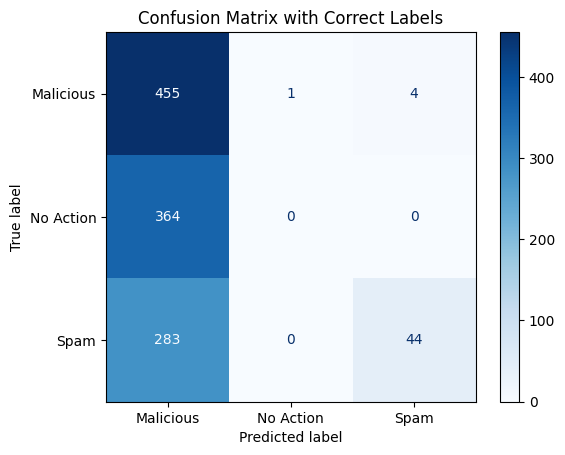

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=en.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Correct Labels")
plt.show()

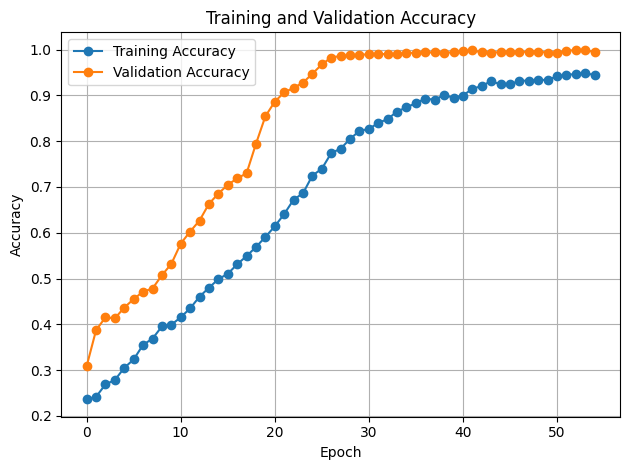

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

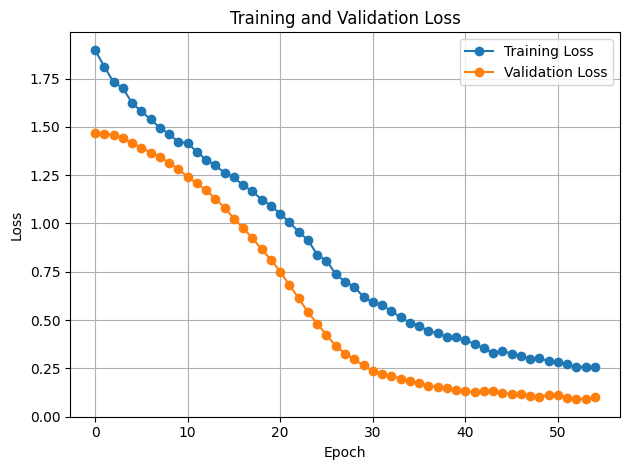

In [ ]:
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
########################################################################3

In [ ]:
## Testing

In [ ]:
import tensorflow as tf
import pickle

In [ ]:

with open("/content/label_encoder-output.pkl", "rb") as f:
    label_encoders_output = pickle.load(f)

In [ ]:
########################################################################
categorical_columns = [
    "request_type",
    "spf_result",
    "dkim_result",
    "dmarc_result",
    "tls_version",
    "ssl_validity_status",
    "unique_parent_process_names",
]

################################################################################
feature_names = [
    "sender_known_malicios",
    "sender_domain_reputation_score",
    "sender_spoof_detected",
    "sender_temp_email_likelihood",
    "dmarc_enforced",
    "packer_detected",
    "any_file_hash_malicious",
    "max_metadata_suspicious_score",
    "malicious_attachment_Count",
    "has_executable_attachment",
    "unscannable_attachment_present",
    "total_yara_match_count",
    "total_ioc_count",
    "max_behavioral_sandbox_score",
    "max_amsi_suspicion_score",
    "any_macro_enabled_document",
    "any_vbscript_javascript_detected",
    "any_active_x_objects_detected",
    "any_network_call_on_open",
    "max_exfiltration_behavior_score",
    "any_exploit_pattern_detected",
    "total_embedded_file_count",
    "max_suspicious_string_entropy_score",
    "max_sandbox_execution_time",
    "unique_parent_process_names",
    "return_path_mismatch_with_from",
    "return_path_known_malicious",
    "return_path_reputation_score",
    "reply_path_known_malicious",
    "reply_path_diff_from_sender",
    "reply_path_reputation_Score",
    "smtp_ip_known_malicious",
    "smtp_ip_geo",
    "smtp_ip_asn",
    "smtp_ip_reputation_score",
    "domain_known_malicious",
    "url_Count",
    "dns_morphing_detected",
    "domain_tech_stack_match_score",
    "is_high_risk_role_targeted",
    "sender_name_similarity_to_vip",
    "urgency_keywords_present",
    "request_type",
    "content_spam_score",
    "user_marked_as_spam_before",
    "bulk_message_indicator",
    "unsubscribe_link_present",
    "marketing-keywords_detected",
    "html_text_ratio",
    "image_only_email",
    "spf_result",
    "dkim_result",
    "dmarc_result",
    "reverse_dns_valid",
    "tls_version",
    "total_links_detected",
    "url_shortener_detected",
    "url_redirect_chain_length",
    "final_url_known_malicious",
    "url_decoded_spoof_detected",
    "url_reputation_score",
    "ssl_validity_status",
    "site_visual_similarity_to_known_brand",
    "url_rendering_behavior_score",
    "link_rewritten_through_redirector",
    "token_validation_success",
    "total_components_detected_malicious",
    "Analysis_of_the_qrcode_if_present",
]


##############################################################################################
default_values = {col: 0 for col in feature_names}  # default numeric value

default_values.update(
    {
        "sender_known_malicios": 0,
        "sender_domain_reputation_score": 0.95,
        "sender_spoof_detected": 0,
        "sender_temp_email_likelihood": 0.0,
        "dmarc_enforced": 1,
        "packer_detected": 0,
        "any_file_hash_malicious": 0,
        "max_metadata_suspicious_score": 0.0,
        "malicious_attachment_Count": 0,
        "has_executable_attachment": 0,
        "unscannable_attachment_present": 0,
        "total_yara_match_count": 0,
        "total_ioc_count": 0,
        "max_behavioral_sandbox_score": 0.0,
        "max_amsi_suspicion_score": 0.0,
        "any_macro_enabled_document": 0,
        "any_vbscript_javascript_detected": 0,
        "any_active_x_objects_detected": 0,
        "any_network_call_on_open": 0,
        "max_exfiltration_behavior_score": 0.0,
        "any_exploit_pattern_detected": 0,
        "total_embedded_file_count": 0,
        "max_suspicious_string_entropy_score": 0.075607,
        "max_sandbox_execution_time": 4.377776483e-107,
        "unique_parent_process_names": '[""]',
        "return_path_mismatch_with_from": 0,
        "return_path_known_malicious": 0,
        "return_path_reputation_score": 0.95,
        "reply_path_known_malicious": 0,
        "reply_path_diff_from_sender": 0,
        "reply_path_reputation_Score": 0.95,
        "smtp_ip_known_malicious": 0,
        "smtp_ip_geo": 0.001,
        "smtp_ip_asn": 0.05,
        "smtp_ip_reputation_score": 0.95,
        "domain_known_malicious": 0,
        "url_Count": 0,
        "dns_morphing_detected": 0,
        "domain_tech_stack_match_score": 1.0,
        "is_high_risk_role_targeted": 0,
        "sender_name_similarity_to_vip": 0.0000000,
        "urgency_keywords_present": 0,
        "request_type": "none",
        "content_spam_score": 0.0,
        "user_marked_as_spam_before": 0,
        "bulk_message_indicator": 0,
        "unsubscribe_link_present": 0,
        "marketing-keywords_detected": 0,
        "html_text_ratio": 0.0,
        "image_only_email": 0,
        "spf_result": "pass",
        "dkim_result": "pass",
        "dmarc_result": "pass",
        "reverse_dns_valid": 1,
        "tls_version": "TLS 1.0",
        "total_links_detected": 0,
        "url_shortener_detected": 0,
        "url_redirect_chain_length": 0,
        "final_url_known_malicious": 0,
        "url_decoded_spoof_detected": 0,
        "url_reputation_score": 0.0,
        "ssl_validity_status": "valid",
        "site_visual_similarity_to_known_brand": 0.0,
        "url_rendering_behavior_score": 0.0000430629,
        "link_rewritten_through_redirector": 0,
        "token_validation_success": 1,
        "total_components_detected_malicious": 0,
        "Analysis_of_the_qrcode_if_present": 2,
    }
)

In [ ]:
with open("/content/le_dkim_result.pkl", "rb") as f:
    le_dkim_result = pickle.load(f)

with open("/content/le_dmarc_result.pkl", "rb") as f1:
    le_dmarc_result = pickle.load(f1)

with open("/content/le_request_type.pkl", "rb") as f2:
    le_request_type = pickle.load(f2)

with open("/content/le_spf_result.pkl", "rb") as f3:
    le_spf_result = pickle.load(f3)

with open("/content/le_ssl_validity_status.pkl", "rb") as f4:
    le_ssl_validity_status = pickle.load(f4)

with open("/content/le_tls_version.pkl", "rb") as f5:
    le_tls_version = pickle.load(f5)

with open("/content/le_unique_parent_process_names.pkl", "rb") as f6:
    le_unique_parent_process_names = pickle.load(f6)

In [ ]:
# df["request_type"] = le_request_type.transform(df["request_type"])

# df["spf_result"] = le_spf_result.transform(df["spf_result"])

# df["dkim_result"] = le_dkim_result.transform(df["dkim_result"])

# df["dmarc_result"] = le_dmarc_result.transform(df["dmarc_result"])

# df["tls_version"] = le_tls_version.transform(df["tls_version"])

# df["ssl_validity_status"] = le_ssl_validity_status.transform(df["ssl_validity_status"])

# df["unique_parent_process_names"] = le_unique_parent_process_names.transform(df["unique_parent_process_names"])


In [ ]:
df["spf_result"].value_counts()

,count
spf_result,
3,5659
0,2319
5,612
1,157
2,88
6,46
4,38


In [ ]:
df_1["spf_result"].value_counts()

In [ ]:
import tensorflow as tf

model_1 = tf.keras.models.load_model(r"/content/ann_model_19-12-2025_v1.h5")

In [ ]:
import joblib

In [ ]:
svd = joblib.load("/content/svd.pkl")

In [ ]:
def predict_1(input_data):
    """
    Improved predict function using encode_dataframe
    """
    data_dict = input_data["data"]

    # Create a single-row DataFrame from input data
    df = pd.DataFrame([data_dict])
    # print(df.head())

    # Fill missing values with defaults
    for col in feature_names:
        if col not in df.columns:
            df[col] = default_values.get(col, 0)

    try:
      df["request_type"] = le_request_type.transform(df["request_type"])
    except:
      df["request_type"] = 10 # none

    try:
      df["spf_result"] = le_spf_result.transform(df["spf_result"])
    except:
      df["spf_result"] = 2 # none

    try:
      df["dkim_result"] = le_dkim_result.transform(df["dkim_result"])
    except:
      df["dkim_result"] = 2 # none

    try:
      df["dmarc_result"] = le_dmarc_result.transform(df["dmarc_result"])
    except:
      df["dmarc_result"] = 2 # none

    try:
      df["tls_version"] = le_tls_version.transform(df["tls_version"])
    except:
      df["tls_version"] = 4  # TLS 1.2

    try:
      df["ssl_validity_status"] = le_ssl_validity_status.transform(df["ssl_validity_status"])
    except:
      df["ssl_validity_status"] = 8 # valid

    try:
      df["unique_parent_process_names"] = le_unique_parent_process_names.transform(df["unique_parent_process_names"])
    except:
      df["unique_parent_process_names"] = 0 #"[""]"

    # print("new === ",df.head())

    # Convert "true"/"false" strings to 1/0
    for col in df.columns:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: 1 if isinstance(x, str) and x.lower() == "true" else
                                              0 if isinstance(x, str) and x.lower() == "false" else x)

    # # Apply categorical encoding using the encoder
    # df_encoded = encode_dataframe(df, inplace=True)

    # # Handle any unknown categorical values
    # for col in categorical_columns:
    #     if col in df.columns:
    #         # If value is not in encoding dict, use default encoded value
    #         if pd.isna(df[col].iloc[0]):
    #             # Get the encoded value for the default
    #             default_cat_value = default_values.get(col, "none")
    #             df[col] = encodings.get(col, {}).get(default_cat_value, 0)

    # # Extract row as list in the correct feature order
    row = df[feature_names].iloc[0].tolist()

    # return row

    #   # Make 2D array
    final_input = [row]
    print("final_inpu = ",final_input)
    # Apply SVD
    X_svd = svd.transform(final_input)

    # Predict
    # prediction = model.predict(X_svd)
    probs = model_1.predict(X_svd)
    pred_class = np.argmax(probs, axis=1)
    # print("Probability = ",probs)
    # print("pred_class === ",pred_class)
    # print("Class === ",label_encoders_output.inverse_transform(pred_class)[0])
    return label_encoders_output.inverse_transform(pred_class)[0]



In [ ]:
import pandas as pd
import os
import numpy as np

def process_excel(excel_file):
    """
    Read Excel, process each row, save results to CSV
    """
    # Read Excel
    df = pd.read_csv(excel_file)
    print(f"Processing {len(df)} rows...")

    results = []

    # Process each row
    for idx, row in df.iterrows():
        # Convert to your format
        json_input = {"data": row.to_dict()}

        # Get prediction
        prediction = predict_1(json_input)

        # Save row + prediction
        row_result = row.to_dict()
        row_result['prediction'] = prediction
        results.append(row_result)

        print(f"Row {idx + 1}: {prediction}")

    # Save to CSV
    output_file = excel_file.replace('.xlsx', '_predictions.csv').replace('.xls', '_predictions.csv')
    pd.DataFrame(results).to_csv(output_file, index=False)

    print(f"Saved to: {output_file}")
    return output_file

# Usage:
# from your_model_file import predict_1
process_excel("/content/real_spam_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/real_spam_data.csv'

In [ ]:
This is my function and i am calling and providing input in this format "predict({ "data": {"reply_path_reputation_score": 0,
  "sender_known_malicious": 0,
  "spf_result": "not available",
  "dkim_result": "none",
  "tls_version": "not available",
  "dmarc_result": "none",
  "ssl_validity_status": "error",
  "total_links_detected": 0,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "sender_domain_reputation_score": 1,
  "return_path_reputation_score": 0.7,
  "reverse_dns_valid": 0,
  "reply_path_diff_from_sender": 0,
  "smtp_ip_known_malicious": 0,
  "sender_name_similarity_to_vip": 0,
  "domain_known_malicious": 0,
  "return_path_mismatch_with_from": 0,
  "packer_detected": 0,
  "any_file_hash_malicious": 0,          # main
  "has_executable_attachment": 0,
  "malicious_attachment_count": 0,
  "max_metadata_suspicious_score": 0.3,
  "unscannable_attachment_present": 1,
  "url_count": 0,
  "smtp_ip_asn": 0.5,
  "html_text_ratio": 0.4926772114821324,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'false',
  "marketing_keywords_detected": 0.20425531914893616,
  "dmarc_enforced": 0,
  "urgency_keywords_present": 0.0,
  "url_rendering_behavior_score": 0.0,
  "analysis_of_qr_if_present": 2,
  "reply_path_known_malicious": 0,
  "smtp_ip_geo": 0.1,
  "total_ioc_count": 3,
  "total_yara_match_count": 1,
  "total_embedded_file_count": 0,
  "any_macro_enabled_document": 0,
  "any_active_x_objects_detected": 0,
  "any_vbscript_javascript_detected": 0,
  "max_suspicious_string_entropy_score": 0.532,
  "sender_spoof_detected": 0,
  "return_path_known_malicious": 0,
  "url_reputation_score": 1.0,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.0,
  "is_high_risk_role_targeted": 1,
  "user_marked_as_spam_before": 0
   }})". Now i want new function where i will provide excel sheet as input your first work is take single single records from that excel sheet convert in my input format and call my function. After your calling my function will provide output.
   your second work is thake that row from excel sheet wich ued for calling my function and output from the function create new csv file save in working directory.

In [ ]:
user ID : ssh u3@65.2.105.246
6UK5iSS2VQAJtC+s

In [ ]:
ou = pd.read_csv("/content/ml_training_MALICIOUS_predictions.csv")

In [ ]:
ou['output']

In [ ]:
print(predict_1({ "data": {"reply_path_reputation_score": 0,
  "sender_known_malicious": 0,
  "spf_result": "not available",
  "dkim_result": "none",
  "tls_version": "not available",
  "dmarc_result": "none",
  "ssl_validity_status": "error",
  "total_links_detected": 0,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "sender_domain_reputation_score": 1,
  "return_path_reputation_score": 0.7,
  "reverse_dns_valid": 0,
  "reply_path_diff_from_sender": 0,
  "smtp_ip_known_malicious": 0,
  "sender_name_similarity_to_vip": 0,
  "domain_known_malicious": 0,
  "return_path_mismatch_with_from": 0,
  "packer_detected": 0,
  "any_file_hash_malicious": 0,          # main
  "has_executable_attachment": 0,
  "malicious_attachment_count": 0,
  "max_metadata_suspicious_score": 0.3,
  "unscannable_attachment_present": 1,
  "url_count": 0,
  "smtp_ip_asn": 0.5,
  "html_text_ratio": 0.4926772114821324,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'false',
  "marketing_keywords_detected": 0.20425531914893616,
  "dmarc_enforced": 0,
  "urgency_keywords_present": 0.0,
  "url_rendering_behavior_score": 0.0,
  "analysis_of_qr_if_present": 2,
  "reply_path_known_malicious": 0,
  "smtp_ip_geo": 0.1,
  "total_ioc_count": 3,
  "total_yara_match_count": 1,
  "total_embedded_file_count": 0,
  "any_macro_enabled_document": 0,
  "any_active_x_objects_detected": 0,
  "any_vbscript_javascript_detected": 0,
  "max_suspicious_string_entropy_score": 0.532,
  "sender_spoof_detected": 0,
  "return_path_known_malicious": 0,
  "url_reputation_score": 1.0,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.0,
  "is_high_risk_role_targeted": 1,
  "user_marked_as_spam_before": 0
   }}))

final_inpu =  [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 1.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.532, 4.377776483e-107, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.95, 0.0, 0.1, 0.5, 0.95, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4926772114821324, 0.0, 2.0, 2.0, 2.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
Warning


In [ ]:
### 2

In [ ]:
print(predict_1({ "data": {"dmarc_enforced": 1,
  "sender_spoof_detected": 0,
  "sender_domain_reputation_score": 1,
  "return_path_mismatch_with_from": 0,
  "return_path_known_malicious": 0,
  "spf_result": "pass",
  "dkim_result": "pass",
  "tls_version": "not available",
  "dmarc_result": "pass",
  "sender_temporary_email_likelihood": 1.0,
  "return_path_reputation_score": 1.0,
  "sender_name_similarity_to_vip": 0,
  "smtp_ip_asn": 0.5,
  "reply_path_diff_from_sender": 0,
  "reply_path_known_malicious": 0,
  "reply_path_reputation_score": 0,
  "domain_known_malicious": 0,
  "url_count": 5,
  "sender_known_malicious": 0,
  "urgency_keywords_present": 0.0,
  "analysis_of_qr_if_present": 2,
  "url_rendering_behavior_score": 0.0,
  "smtp_ip_known_malicious": 0,
  "ssl_validity_status": "valid",
  "total_links_detected": 5,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "user_marked_as_spam_before": 0,
  "is_high_risk_role_targeted": 1,
  "html_text_ratio": 0.09649892335911955,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'true',
  "marketing_keywords_detected": 0.11564211807668898,
  "reverse_dns_valid": 0,
  "url_reputation_score": 0.93,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.35,
  "smtp_ip_geo": 0.9
   }}))

final_inpu =  [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.075607, 4.377776483e-107, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.95, 0.0, 0.9, 0.5, 0.95, 0.0, 0.0, 0.0, 0.35, 1.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.09649892335911955, 0.0, 3.0, 3.0, 3.0, 0.0, 4.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.93, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
No Action


In [ ]:
print(predict_1({ "data": {"dmarc_enforced": 1,
  "sender_spoof_detected": 0,
  "sender_domain_reputation_score": 1,
  "return_path_mismatch_with_from": 0,
  "return_path_known_malicious": 0,
  "spf_result": "pass",
  "dkim_result": "pass",
  "tls_version": "not available",
  "dmarc_result": "pass",
  "sender_temporary_email_likelihood": 1.0,
  "return_path_reputation_score": 1.0,
  "sender_name_similarity_to_vip": 0,
  "smtp_ip_asn": 0.5,
  "reply_path_diff_from_sender": 0,
  "reply_path_known_malicious": 1,
  "reply_path_reputation_score": 0,
  "domain_known_malicious": 1,
  "url_count": 5,
  "sender_known_malicious": 0,
  "urgency_keywords_present": 0.0,
  "analysis_of_qr_if_present": 2,
  "url_rendering_behavior_score": 0.0,
  "smtp_ip_known_malicious": 0,
  "ssl_validity_status": "valid",
  "total_links_detected": 5,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "user_marked_as_spam_before": 0,
  "is_high_risk_role_targeted": 1,
  "html_text_ratio": 0.09649892335911955,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'true',
  "marketing_keywords_detected": 0.11564211807668898,
  "reverse_dns_valid": 0,
  "url_reputation_score": 0.93,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.35,
  "smtp_ip_geo": 0.09
 }}))

final_inpu =  [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.075607, 4.377776483e-107, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.95, 0.0, 0.09, 0.5, 0.95, 1.0, 0.0, 0.0, 0.35, 1.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.09649892335911955, 0.0, 3.0, 3.0, 3.0, 0.0, 4.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.93, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Warning


In [ ]:
#### 3

In [ ]:
  # original
  print(predict_1({ "data": {  "dmarc_enforced": 0,
  "spf_result": "pass",
  "dkim_result": "pass",
  "tls_version": "not available",
  "dmarc_result": "pass",
  "reverse_dns_valid": 0,
  "url_count": 0,
  "smtp_ip_asn": 0.5,
  "html_text_ratio": 0.16387236343969713,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'false',
  "marketing_keywords_detected": 0.09912536443148688,
  "domain_known_malicious": 0,
  "user_marked_as_spam_before": 0,
  "packer_detected": 0,
  "any_file_hash_malicious": 0,
  "has_executable_attachment": 0,
  "malicious_attachment_count": 0,
  "max_metadata_suspicious_score": 0.0,
  "unscannable_attachment_present": 0,
  "sender_known_malicious": 0,
  "is_high_risk_role_targeted": 0,
  "sender_spoof_detected": 0,
  "sender_name_similarity_to_vip": 0,
  "analysis_of_qr_if_present": 2,
  "ssl_validity_status": "no_ssl",
  "total_links_detected": 2,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "smtp_ip_geo": 0.25,
  "reply_path_known_malicious": 0,
  "return_path_reputation_score": 1.0,
  "reply_path_diff_from_sender": 0,
  "urgency_keywords_present": 0.0,
  "sender_temporary_email_likelihood": 1.0,
  "return_path_mismatch_with_from": 0,
  "url_rendering_behavior_score": 0.0,
  "reply_path_reputation_score": 1,
  "return_path_known_malicious": 0,
  "url_reputation_score": 1.0,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.25,
  "total_ioc_count": 0,
  "total_yara_match_count": 0,
  "total_embedded_file_count": 0,
  "any_macro_enabled_document": 0,
  "any_active_x_objects_detected": 0,
  "any_vbscript_javascript_detected": 1,
  "max_suspicious_string_entropy_score": 0.647
 }}))

In [ ]:
a = [[9.9385601e-01,1.9843868e-04,3.1218727e-04,5.6333272e-03]]

In [ ]:
a[0][0]

In [ ]:
print(predict_1({ "data": { "dmarc_enforced": 0,
  "spf_result": "pass",
  "dkim_result": "pass",
  "tls_version": "not available",
  "dmarc_result": "pass",
  "reverse_dns_valid": 0,
  "url_count": 0,
  "smtp_ip_asn": 0.05,
  "html_text_ratio": 0.16387236343969713,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'false',
  "marketing_keywords_detected": 0.09912536443148688,
  "domain_known_malicious": 0,
  "user_marked_as_spam_before": 0,
  "packer_detected": 0,
  "any_file_hash_malicious": 0,
  "has_executable_attachment": 0,
  "malicious_attachment_count": 0,
  "max_metadata_suspicious_score": 0.0,
  "unscannable_attachment_present": 0,
  "sender_known_malicious": 0,
  "is_high_risk_role_targeted": 0,
  "sender_spoof_detected": 0,
  "sender_name_similarity_to_vip": 0,
  "analysis_of_qr_if_present": 2,
  "ssl_validity_status": "no_ssl",
  "total_links_detected": 2,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "smtp_ip_geo": 0.05,
  "reply_path_known_malicious": 0,
  "return_path_reputation_score": 1.0,
  "reply_path_diff_from_sender": 0,
  "urgency_keywords_present": 0.0,
  "sender_temporary_email_likelihood": 0.0,
  "return_path_mismatch_with_from": 0,
  "url_rendering_behavior_score": 0.0,
  "reply_path_reputation_score": 1,
  "return_path_known_malicious": 0,
  "url_reputation_score": 1.0,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.05,
  "total_ioc_count": 0,
  "total_yara_match_count": 0,
  "total_embedded_file_count": 0,
  "any_macro_enabled_document": 0,
  "any_active_x_objects_detected": 0,
  "any_vbscript_javascript_detected": 0,
  "max_suspicious_string_entropy_score": 0.0647
 }}))

In [ ]:
## 4

In [ ]:
 print(predict_1({ "data": {"spf_result": "pass",
  "dkim_result": "pass",
  "tls_version": "not available",
  "dmarc_result": "pass",
  "reverse_dns_valid": 0,
  "sender_temporary_email_likelihood": 0.0,
  "urgency_keywords_present": 0.0,
  "sender_known_malicious": 0,
  "dmarc_enforced": 0,
  "smtp_ip_known_malicious": 0,
  "is_high_risk_role_targeted": 0,
  "sender_name_similarity_to_vip": 0,
  "return_path_known_malicious": 0,
  "ssl_validity_status": "valid",
  "total_links_detected": 2,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "url_count": 0,
  "url_reputation_score": 1.0,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.25,
  "html_text_ratio": 0.10677906568317529,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'false',
  "marketing_keywords_detected": 0.04081632653061225,
  "domain_known_malicious": 0,
  "return_path_mismatch_with_from": 0,
  "sender_spoof_detected": 0,
  "url_rendering_behavior_score": 0.0,
  "user_marked_as_spam_before": 0,
  "analysis_of_qr_if_present": 2,
  "reply_path_reputation_score": 1,
  "reply_path_known_malicious": 0,
  "reply_path_diff_from_sender": 0,
  "smtp_ip_geo": 0.25,
  "smtp_ip_asn": 0.3,
  "return_path_reputation_score": 1.0
   }}))

In [ ]:
 print(predict({ "data": {"spf_result": "pass",
  "dkim_result": "pass",
  "tls_version": "not available",
  "dmarc_result": "pass",
  "reverse_dns_valid": 0,
  "sender_temporary_email_likelihood": 1.0,
  "urgency_keywords_present": 0.0,
  "sender_known_malicious": 0,
  "dmarc_enforced": 0,
  "smtp_ip_known_malicious": 0,
  "is_high_risk_role_targeted": 0,
  "sender_name_similarity_to_vip": 0,
  "return_path_known_malicious": 0,
  "ssl_validity_status": "valid",
  "total_links_detected": 2,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "url_count": 0,
  "url_reputation_score": 1.0,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.05,
  "html_text_ratio": 0.10677906568317529,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'false',
  "marketing_keywords_detected": 0.04081632653061225,
  "domain_known_malicious": 0,
  "return_path_mismatch_with_from": 0,
  "sender_spoof_detected": 0,
  "url_rendering_behavior_score": 0.0,
  "user_marked_as_spam_before": 0,
  "analysis_of_qr_if_present": 2,
  "reply_path_reputation_score": 1,
  "reply_path_known_malicious": 0,
  "reply_path_diff_from_sender": 0,
  "smtp_ip_geo": 0.85,
  "smtp_ip_asn": 0.95,
  "return_path_reputation_score": 1.0
   }}))

In [ ]:
###5

In [ ]:
print(predict({ "data": {  "spf_result": "pass",
  "dkim_result": "pass",
  "tls_version": "not available",
  "dmarc_result": "pass",
  "reverse_dns_valid": 0,
  "sender_temporary_email_likelihood": 0.0,
  "urgency_keywords_present": 0.0,
  "sender_known_malicious": 0,
  "dmarc_enforced": 0,
  "smtp_ip_known_malicious": 0,
  "is_high_risk_role_targeted": 0,
  "sender_name_similarity_to_vip": 0,
  "return_path_known_malicious": 0,
  "ssl_validity_status": "valid",
  "total_links_detected": 2,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "url_count": 0,
  "url_reputation_score": 1.0,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.910000,
  "html_text_ratio": 0.870000,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'false',
  "marketing_keywords_detected": 0.171732,
  "domain_known_malicious": 0,
  "return_path_mismatch_with_from": 0,
  "sender_spoof_detected": 0,
  "url_rendering_behavior_score": 0.0,
  "user_marked_as_spam_before": 0,
  "analysis_of_qr_if_present": 2,
  "reply_path_reputation_score": 1,
  "reply_path_known_malicious": 0,
  "reply_path_diff_from_sender": 0,
  "smtp_ip_geo": 0.89,
  "smtp_ip_asn": 0.95,
  "return_path_reputation_score": 1.0}}))

In [ ]:
print(predict({ "data":{
    "dkim_result": "pass",
    "dmarc_enforced": 1,
    "dmarc_result": "pass",
    "domain_known_malicious": 0,
    "is_high_risk_role_targeted": 0,
    "reply_path_diff_from_sender": 0,
    "reply_path_known_malicious": 0,
    "reply_path_reputation_score": 1,
    "return_path_known_malicious": 1,
    "return_path_mismatch_with_from": 0,
    "return_path_reputation_score": 0.7,
    "reverse_dns_valid": 0,
    "sender_domain_reputation_score": 0.7,
    "sender_known_malicious": 0,
    "sender_spoof_detected": 0,
    "sender_temporary_email_likelihood": 1,
    "spf_result": "pass",
    "tls_version": "not available",
    "url_count": 0
  }}))

In [ ]:
print(predict({ "data":{
  "reverse_dns_valid": 0,
  "dmarc_enforced": 0,
  "analysis_of_qr_if_present": 2,
  "content_spam_score": 0.0,
  "smtp_ip_geo": 0.5,
  "sender_spoof_detected": 0,
  "spf_result": 'none',
  "dkim_result": 'none',
  "tls_version": 'not available',
  "dmarc_result": 'none',
  "html_text_ratio": 1.0,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'true',
  "marketing_keywords_detected": 0.12956810631229235,
  "sender_known_malicious": 0,
  "sender_name_similarity_to_vip": 0,
  "domain_known_malicious": 0,
  "sender_domain_reputation_score": 0.35,
  "sender_temporary_email_likelihood": 0,
  "url_count": 3,
  "max_amsi_suspicion_score": 0.0,
  "urgency_keywords_present": 0.0,
  "return_path_mismatch_with_from": 0,
  "any_network_call_on_open": 0,
  "max_sandbox_execution_time": 0.0,
  "unique_parent_process_names": 'null',
  "any_exploit_pattern_detected": 0,
  "max_behavioral_sandbox_score": 0.0,
  "max_exfiltration_behavior_score": 0.0,
  "total_components_detected_malicious": 0,
  "reply_path_diff_from_sender": 1,
  "url_reputation_score": 0.74,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 1,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.27,
  "url_rendering_behavior_score": 0.0,
  "is_high_risk_role_targeted": 0,
  "return_path_known_malicious": 0,
  "ssl_validity_status": 'no_ssl',
  "total_links_detected": 3,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "user_marked_as_spam_before": 0,
  "reply_path_known_malicious": 0,
  "reply_path_reputation_score": 0.7,
  "return_path_reputation_score": 0.35
}}))


In [ ]:
No_Action_df = d[d['Final Classification'] == "No Action"]

In [ ]:
mean_float = No_Action_df.select_dtypes(include=["float64"]).mean()
print(mean_float)

In [ ]:
print(predict({ "data": { "dmarc_enforced": 0,
  "ssl_validity_status": "error",
  "total_links_detected": 0,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "sender_name_similarity_to_vip": 0,
  "spf_result": "pass",
  "dkim_result": "pass",
  "tls_version": "not available",
  "dmarc_result": "pass",
  "url_count": 0,
  "reverse_dns_valid": 0,
  "sender_known_malicious": 0,
  "sender_spoof_detected": 0,
  "smtp_ip_asn": 0.05,
  "smtp_ip_geo": 0.05,
  "return_path_mismatch_with_from": 0,
  "return_path_known_malicious": 0,
  "return_path_reputation_score": 1.0,
  "reply_path_reputation_score": 1,
  "reply_path_known_malicious": 0,
  "domain_known_malicious": 0,
  "analysis_of_qr_if_present": 2,
  "sender_temporary_email_likelihood": 1.0,
  "urgency_keywords_present": 0.0,
  "is_high_risk_role_targeted": 0,
  "reply_path_diff_from_sender": 0,
  "html_text_ratio": 0.49114331723027377,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'false',
  "marketing_keywords_detected": 0.2452830188679245,
  "url_rendering_behavior_score": 0.0,
  "user_marked_as_spam_before": 0,
  "url_reputation_score": 1.0,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.0}}))

In [ ]:
print(predict({ "data": {"return_path_mismatch_with_from": 0,
  "sender_name_similarity_to_vip": 0,
  "url_count": 0,
  "sender_spoof_detected": 0,
  "url_reputation_score": 1.0,
  "dns_morphing_detected": 'false',
  "url_shortener_detected": 'false',
  "url_redirect_chain_length": 0,
  "url_decoded_spoof_detected": 'false',
  "domain_tech_stack_match_score": 0.0,
  "reverse_dns_valid": 0,
  "spf_result": "pass",
  "dkim_result": "pass",
  "tls_version": "not available",
  "dmarc_result": "pass",
  "ssl_validity_status": "error",
  "total_links_detected": 0,
  "token_validation_success": 0,
  "final_url_known_malicious": 0,
  "link_rewritten_through_redirector": 0,
  "site_visual_similarity_to_known_brand": 0.0,
  "dmarc_enforced": 0,
  "smtp_ip_known_malicious": 0,
  "sender_temporary_email_likelihood": 0.0,
  "domain_known_malicious": 0,
  "html_text_ratio": 0.11577752553916004,
  "image_only_email": 'false',
  "bulk_message_indicator": 'false',
  "unsubscribe_link_present": 'false',
  "marketing_keywords_detected": 0.022368421052631585,
  "smtp_ip_geo": 0.025,
  "analysis_of_qr_if_present": 2,
  "urgency_keywords_present": 0.0,
  "url_rendering_behavior_score": 0.0,
  "reply_path_diff_from_sender": 0,
  "is_high_risk_role_targeted": 0,
  "user_marked_as_spam_before": 0,
  "smtp_ip_asn": 0.05,
  "return_path_reputation_score": 0.0,
  "reply_path_reputation_score": 1}}))